<a href="https://colab.research.google.com/github/ClaudioH19/TareasML/blob/master/PROYECTO_FINAL/proyecto_ecg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FASE 0: Importar datos desde el drive y crear el CSV curado con gdown y pandas**

Se instala gdown para descargar desde google drive y descomprimir el zip

In [69]:
# Instalar gdown para descargar desde Google Drive
!pip install -q gdown

# Descargar el ZIP desde Drive
import gdown
zip_id = "1g_FI6gG1LClmoMuIm4_QG60NKp4q7yjE"
gdown.download(f"https://drive.google.com/uc?id={zip_id}", "ecg_signals.zip", quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1g_FI6gG1LClmoMuIm4_QG60NKp4q7yjE
From (redirected): https://drive.google.com/uc?id=1g_FI6gG1LClmoMuIm4_QG60NKp4q7yjE&confirm=t&uuid=cc9b7df3-151d-49e5-baa1-92944417b735
To: /content/ecg_signals.zip
100%|██████████| 99.2M/99.2M [00:00<00:00, 249MB/s]


'ecg_signals.zip'

In [70]:
# Descomprimir el archivo ZIP
import zipfile
import os

with zipfile.ZipFile("ecg_signals.zip", 'r') as zip_ref:
    zip_ref.extractall("ecg_data")

# Listar algunos archivos para verificar
os.listdir("ecg_data/training2017")[:10]

['A07321.mat',
 'A00243.hea',
 'A07446.mat',
 'A04196.hea',
 'A02661.mat',
 'A02088.hea',
 'A03462.hea',
 'A04558.mat',
 'A02154.hea',
 'A01631.mat']

Seleccionar 15 Señales N y 15 señales A

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os

# Cargar archivo de referencia
ref_path = "ecg_data/training2017/REFERENCE.csv"
ref_df = pd.read_csv(ref_path, header=None, names=['id', 'label'])

# Filtrar y seleccionar 15 muestras de cada clase
normal_df = ref_df[ref_df['label'] == 'N'].sample(n=15, random_state=42)
afib_df = ref_df[ref_df['label'] == 'A'].sample(n=15, random_state=42)

# Combinar
subset = pd.concat([normal_df, afib_df])

# Verificar
print(subset.head())


          id label
7911  A07912     N
1156  A01157     N
116   A00117     N
5689  A05690     N
8122  A08123     N


Visualizar las señales

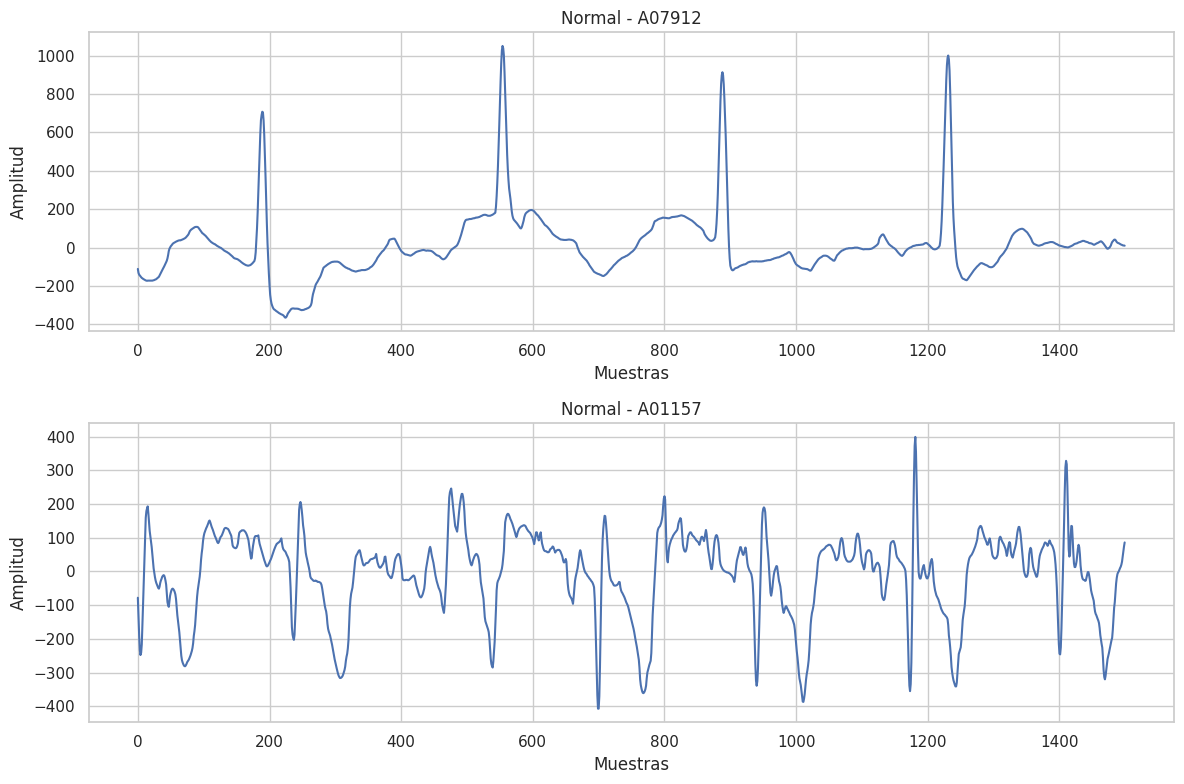

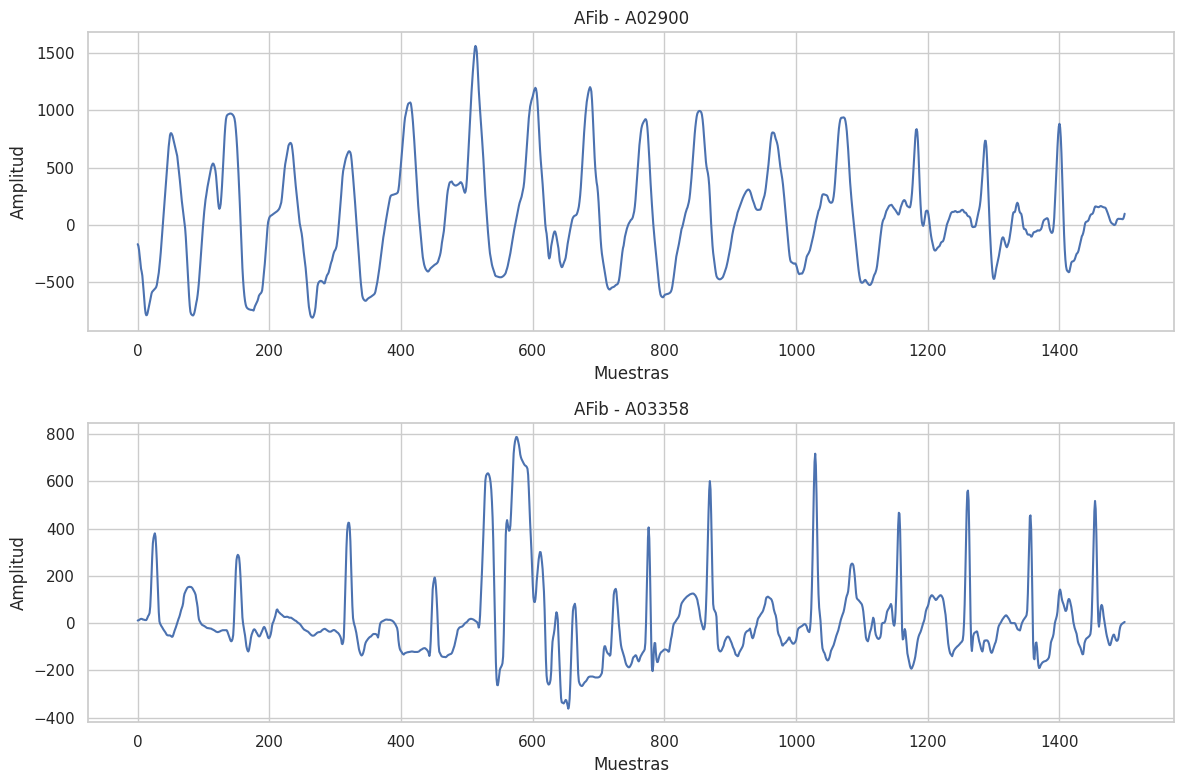

In [72]:
# Función de visualización
def plot_signals_from_subset(df, label_char, title_label, n=2):
    filtered = df[df['label'] == label_char]
    plt.figure(figsize=(12, 4 * n))
    for i in range(n):
        record_id = filtered.iloc[i]['id']
        mat_path = os.path.join("ecg_data/training2017", f"{record_id}.mat")
        mat = loadmat(mat_path)
        signal = mat['val'][0]

        plt.subplot(n, 1, i + 1)
        plt.plot(signal[:1500])  # ~5s si fs=300Hz
        plt.title(f"{title_label} - {record_id}")
        plt.xlabel("Muestras")
        plt.ylabel("Amplitud")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Visualizar 2 normales y 2 AFib
plot_signals_from_subset(subset, 'N', "Normal", n=2)
plot_signals_from_subset(subset, 'A', "AFib", n=2)



Una vez, seleccionada 15 señales de cada tipo al azar, extraemos las características:
- mean_rr
- std_rr
- skew_rr
- kurt_rr

Para crear el .csv curado, se incorpora un filtro bandpass para **eliminar ruido** de baja frecuencia y alta frecuencia, mejorando así la detección de los picos R. Esto permite obtener intervalos RR más precisos y reducir errores causados por artefactos, lo que permite obtener resultados más fieles a la variabilidad del ritmo cardíaco.

In [73]:
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis
import numpy as np
import pandas as pd
from scipy.io import loadmat
import os

# Ruta base
base_path = "ecg_data/training2017"

# Subconjunto con 15 normales y 15 AFib
# variable: subset

from scipy.signal import butter, filtfilt

def bandpass_filter(signal, fs=300, low=0.5, high=40, order=2):
    nyquist = 0.5 * fs
    lowcut = low / nyquist
    highcut = high / nyquist
    b, a = butter(order, [lowcut, highcut], btype='band')
    return filtfilt(b, a, signal)

# Función para extraer características de una señal
def compute_rr_features(signal, fs=300):
    # Filtro paso banda para limpiar ruido
    signal = bandpass_filter(signal, fs)

    # Detección de picos más robusta
    peaks, _ = find_peaks(signal, distance=fs*0.3, prominence=100, height=200)

    if len(peaks) < 2:
        return None

    rr_intervals = np.diff(peaks) * (1000 / fs)  # ms

    # Eliminar RR extremos que podrían ser errores
    rr_intervals = rr_intervals[(rr_intervals > 300) & (rr_intervals < 2000)]

    if len(rr_intervals) < 2:
        return None

    return {
        'mean_rr': np.mean(rr_intervals),
        'std_rr': np.std(rr_intervals),
        'skew_rr': skew(rr_intervals),
        'kurt_rr': kurtosis(rr_intervals)
    }


# Lista para guardar resultados
records = []

# Iteramos dentro del subset de 30 señales
for _, row in subset.iterrows():
    record_id = row['id']
    label = 'Normal' if row['label'] == 'N' else 'AFib'
    mat_path = os.path.join(base_path, f"{record_id}.mat")

    try:
        mat = loadmat(mat_path)
        signal = mat['val'][0]
        features = compute_rr_features(signal)
        if features:
            features['id'] = record_id
            features['label'] = label
            records.append(features)
    except Exception as e:
        print(f"Error en {record_id}: {e}")

# Crear DataFrame
curado_df = pd.DataFrame(records)

# Reordenar columnas
curado_df = curado_df[['id', 'mean_rr', 'std_rr', 'skew_rr', 'kurt_rr', 'label']]

# Guardar CSV
curado_df.to_csv("ecg_rr_features_curado.csv", index=False)

# **FASE 1: Inspección del dataset, visualización de distribuciones y conclusiones**

Comenzamos cargando y explorando el *dataset*

In [74]:
import pandas as pd

# Cargar archivo curado
df = pd.read_csv("ecg_rr_features_curado.csv")

# Ver las primeras 5 filas
df.head()

,id,mean_rr,std_rr,skew_rr,kurt_rr,label
0,A07912,1134.400000,36.058225,0.898910,1.144442,Normal
1,A01157,970.357143,355.889607,1.096209,-0.001675,Normal
2,A00117,854.411765,162.787645,-0.164251,-0.059193,Normal
3,A08123,902.828283,81.037553,2.289251,8.583966,Normal
4,A00647,767.192982,36.948885,0.063920,10.730166,Normal


Inspección básica:

In [75]:
# Tipos de datos por columna
print("Tipos de datos:")
print(df.dtypes)

# Conteo por clase
print("\nDistribución de clases:")
print(df['label'].value_counts())

# Estadísticas básicas
print("\nDescripción estadística:")
print(df.describe())

# Estadísticas básicas
# Describe para cada clase por separado
normal_stats = df[df['label'] == 'Normal'].describe()
afib_stats = df[df['label'] == 'AFib'].describe()

# Renombrar columnas para claridad
normal_stats.columns = [f"{col}_Normal" for col in normal_stats.columns]
afib_stats.columns = [f"{col}_AFib" for col in afib_stats.columns]

# Combinar ambos DataFrames horizontalmente
descripcion_por_clase = pd.concat([normal_stats, afib_stats], axis=1)

# Mostrar
print("Descripción estadística por clase:\n")
display(descripcion_por_clase)




Tipos de datos:
id          object
mean_rr    float64
std_rr     float64
skew_rr    float64
kurt_rr    float64
label       object
dtype: object

Distribución de clases:
label
AFib      15
Normal    13
Name: count, dtype: int64

Descripción estadística:
           mean_rr      std_rr    skew_rr    kurt_rr
count    28.000000   28.000000  28.000000  28.000000
mean    751.254170  153.554661   0.822729   3.291037
std     214.565158   95.642838   1.370117   5.541027
min     403.108108   22.377485  -3.037810  -1.670519
25%     587.079412   85.875299   0.006878  -0.652354
50%     741.685922  126.580419   0.736620   0.872262
75%     906.600379  208.081045   1.522776   5.854099
max    1151.600000  355.889607   3.873428  19.104964
Descripción estadística por clase:



,mean_rr_Normal,std_rr_Normal,skew_rr_Normal,kurt_rr_Normal,mean_rr_AFib,std_rr_AFib,skew_rr_AFib,kurt_rr_AFib
count,13.000000,13.000000,13.000000,13.000000,15.000000,15.000000,15.000000,15.000000
mean,825.371964,149.080841,0.496502,3.848690,687.018749,157.431971,1.105459,2.807738
std,159.972919,124.591032,1.598055,6.519627,239.438020,65.586973,1.116661,4.715989
min,548.024691,22.377485,-3.037810,-1.385050,403.108108,87.479437,-0.508596,-1.670519
25%,716.178862,55.775779,-0.164251,-0.851482,537.373737,104.304920,0.472295,-0.485527
50%,817.272727,81.062884,0.256912,0.600082,592.801932,141.875108,0.949775,1.356943
75%,917.916667,249.105824,1.096209,8.583966,826.539961,186.342792,1.928477,4.766958
max,1134.400000,355.889607,3.873428,19.104964,1151.600000,289.658979,3.267194,15.596585


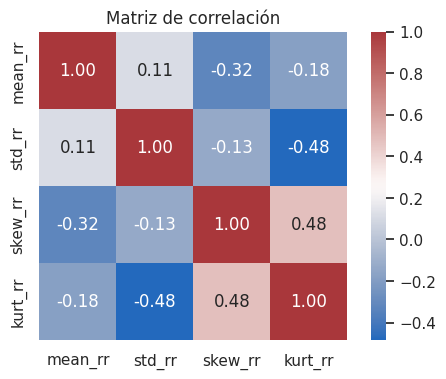

In [76]:
#Mapa de Correlaciones
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
corr = df[['mean_rr','std_rr','skew_rr','kurt_rr']].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", square=True)
plt.title("Matriz de correlación")
plt.show()


**Revisión:**

Se aprecia que todas las variables del dataset son de tipo numérico, sin presencia de valores nulos. Tras aplicar un filtrado paso banda y una detección más robusta de picos, los valores de std_rr, skew_rr y kurt_rr reflejan de forma más precisa la variabilidad y forma de la distribución entre latidos. En particular, destaca que la clase AFib presenta mayor dispersión y asimetría, tal como se espera clínicamente en presencia de arritmias.

Por otro lado, la matriz de correlación muestra una relación moderada entre skew_rr y kurt_rr, lo que indica que señales con distribución sesgada tienden también a tener colas más pronunciadas. En contraste, std_rr mantiene baja correlación con el resto de las variables, lo cual sugiere que puede aportar información complementaria y no redundante. Esto es clínicamente coherente, ya que la variabilidad del ritmo es una característica distintiva de la fibrilación auricular.

Visualizando las distribuciones

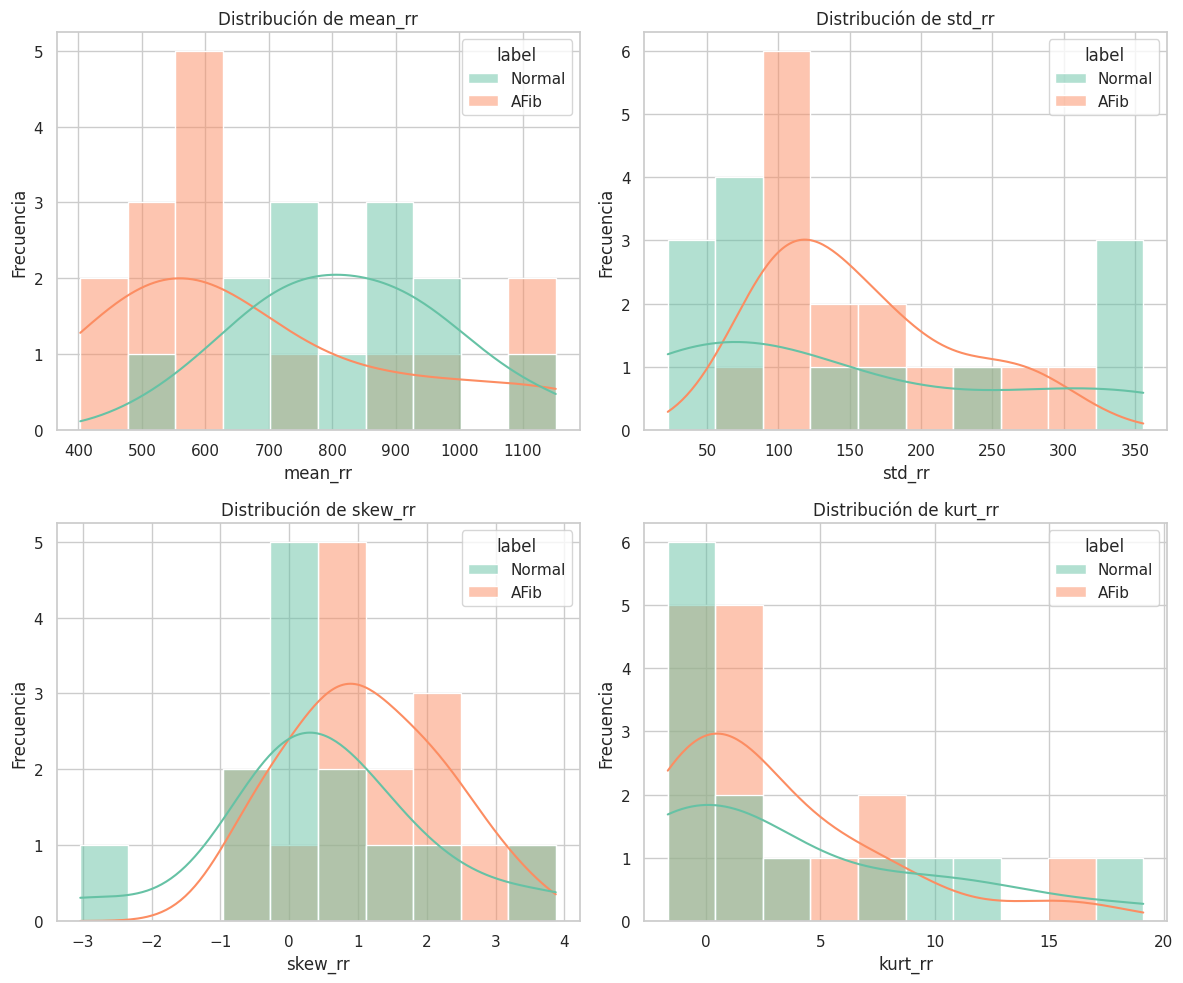

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

features = ['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']
palette = {'Normal': '#66c2a5', 'AFib': '#fc8d62'}

plt.figure(figsize=(12, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    ax = sns.histplot(data=df, x=feature, hue='label', kde=True, palette=palette, bins=10)
    ax.set_title(f"Distribución de {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Frecuencia")

    # Obtener leyenda desde los handles y labels reales
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles=handles, labels=labels, title="Clase")

plt.tight_layout()
plt.show()


**Interpretación:**

Las distribuciones de los estadísticos derivados del intervalo RR muestran una diferenciación clara entre clases tras el filtrado. En mean_rr, los registros normales tienden a presentar intervalos RR mayores (menor frecuencia cardíaca), mientras que los AFib se agrupan en torno a valores más bajos, lo que es consistente con una mayor frecuencia en esta condición. La variable std_rr evidencia que los AFib presentan una mayor dispersión entre latidos, reflejando la irregularidad típica de esta arritmia. En cuanto a la forma de las distribuciones, skew_rr y kurt_rr muestran colas más largas y asimetrías más marcadas en AFib, lo cual puede deberse a la presencia de intervalos anómalos o más extremos. Estas diferencias respaldan la utilidad de estas variables como posibles discriminadores entre ritmos normales y fibrilación auricular.

**Conclusión General:**
El análisis descriptivo y visual de las señales mostró que las métricas RR permiten diferenciar entre ritmos normales y fibrilación auricular,
especialmente en std_rr, skew_rr y kurt_rr. Estas diferencias se volvieron más evidentes al aplicar un filtrado paso banda, tras intentar
analizar los datos con una extracción de features menos robusta, lo que permite destacar la importancia de eliminar el ruido.
Un buen preprocesamiento mejora la detección de picos y asegura que las características extraídas reflejen
de forma confiable la actividad cardíaca real.

**¿Qué variables parecen diferenciar más entre clases?**
La variable que más destaca es std_rr, ya que muestra una diferencia notable entre clases: los registros AFib presentan mayor dispersión entre intervalos RR,
lo que concuerda con la variabilidad característica de esta arritmia.
También destacan, en menor medida, skew_rr y kurt_rr, ya que AFib tiende a mostrar distribuciones más asimétricas y con valores extremos, reflejando una
mayor irregularidad.

**¿Qué aspectos del dataset llaman la atención?**
Uno de los aspectos más llamativos es cómo el preprocesamiento influye directamente en la calidad de las métricas: sin filtrado, las estadísticas pueden
ser engañosas, mostrando incluso mayor variabilidad en registros normales.
También destaca que aunque el número de registros es pequeño, se logra evidenciar cierta separación entre clases,